In [26]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
from dateutil import tz
from datetime import datetime 
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin ,BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from tensorflow.python import keras
from IPython.display import clear_output
import psycopg2
import joblib
import pydot
import graphviz
plt.style.use('ggplot')
mpl.rcParams['figure.figsize']=(15,8)
pd.set_option('display.max_columns',None)



# 1. Preprocessing
## 1.1 Load and split

Number of Training samples: 36915
Number of Validation samples: 6515


/home/adminn/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/adminn/.local/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,result
phenomenonTime,
2018-05-17 15:00:00,-0.576471
2018-05-17 15:15:00,-0.647059
2018-05-17 15:30:00,-0.482353
2018-05-17 15:45:00,-0.576471
2018-05-17 16:00:00,-0.717647


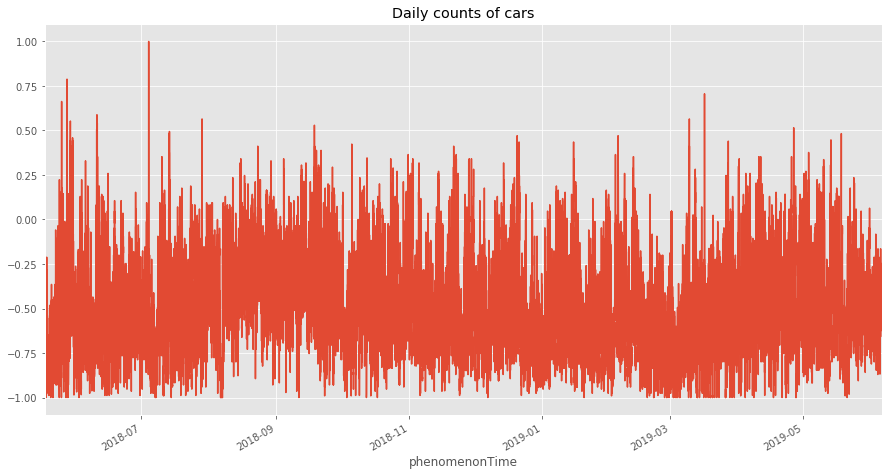

In [280]:
DATA_FILE_PATH='data/camera.csv'
TARGET_COLUMN='result'
TARGET_ENTITY='cars_count'
TEST_FRACTION_SPLIT=0.15
SAMPLEING_FREQUENCY='15min'
TIME_SHIFT_STEPS=24*4
BATCH_SIZE=4*4
LOAD_LIMIT=None

def load_data(cvs_path,entity='cars_count', sampleing_interval='24h',nrows=None):
    """Pandas resample can not work with time zone aware datetime
    We first convert datetime to target local time zone and then
    just remove the timezone info from it ( Essentialy removing the offset)"""
    df=pd.read_csv(DATA_FILE_PATH)
    df.drop(['cameraId'],inplace=True,axis=1)
    df=df[df['label']=='cars_count']
    df['phenomenonTime']=pd.to_datetime(df['phenomenonTime'],utc=True)
    df=df.set_index(pd.DatetimeIndex(df['phenomenonTime']))
    df.index=df.index.tz_convert('America/Edmonton')
    df.index=df.index.tz_localize(None)
    df=df.resample(sampleing_interval).mean()
    #drop nulls
    df.dropna(inplace=True,axis=0)
    return df

def split_data(df, test_fraction=0.2):
    TRAIN_SIZE=int((1-TEST_FRACTION_SPLIT)*df.shape[0])
    df_train =df.iloc[:TRAIN_SIZE,:]
    df_test=df.iloc[TRAIN_SIZE:,:]
    return df_train ,df_test

data=load_data(DATA_FILE_PATH,sampleing_interval=SAMPLEING_FREQUENCY, nrows=LOAD_LIMIT)
df_train,df_test=split_data(data, test_fraction=TEST_FRACTION_SPLIT)
#Ftting Scaling
scaler=MinMaxScaler(feature_range=(-1,1)).fit(df_train['result'].values.reshape(-1,1))
df_train['result']=scaler.transform(df_train['result'].values.reshape(-1,1))
df_test['result']=scaler.transform(df_test['result'].values.reshape(-1,1))

print('Number of Training samples:',df_train.shape[0])
print('Number of Validation samples:',df_test.shape[0])
data.head()
display(df_train.head())
plt.title('Daily counts of cars')
df_train['result'].plot()

## 1.2 Transformations

### 1.2.1 Reshaping

In [390]:
def get_timeseries(data,steps,target_column):
  merged=None
  y=None
  for column in data.columns.tolist():
      df=data[[column]].copy()
      for i in range(1,steps+1):
        df[f'{column}{i}']=df[column].shift(-i)
      df.dropna(inplace=True,axis=0)
      
      if column==target_column:
        y=df[f'{column}{steps}'].values
      df.drop([f'{column}{steps}'],inplace=True,axis=1)  
      df[f'{column}_merged']=df.values.tolist()
      df.drop([f'{column}'],inplace=True,axis=1)
      for i in range(1,steps):
        df.drop([f'{column}{i}'],inplace=True,axis=1)
        
  return df ,y
  
train ,y_train = get_timeseries (df_train.copy(),TIME_SHIFT_STEPS,'result')
X_train=np.array(train['result_merged'].values.tolist()).reshape(-1,NUMBER_OF_FEATURE,TIME_SHIFT_STEPS)

test ,y_test = get_timeseries (df_test.copy(),TIME_SHIFT_STEPS,'result')
X_test=np.array(test['result_merged'].values.tolist()).reshape(-1,NUMBER_OF_FEATURE,TIME_SHIFT_STEPS,)

print('X_train shape:',X_train.shape)
print('X_val shape:',X_test.shape)

X_train shape: (36819, 1, 96)
X_val shape: (6419, 1, 96)


In [391]:
def get_categorical(data,steps):
  merged=None
  for column in data.columns.tolist():
      df=data[[column]]
      for i in range(1,steps+1):
        df[f'{column}{i}']=df[column].shift(-i)
      df.dropna(inplace=True,axis=0)
      df.drop([f'{column}{steps}'],inplace=True,axis=1)
      df[f'{column}_merged']=df.values.tolist()
      df.drop([f'{column}'],inplace=True,axis=1)
      for i in range(1,steps):
        df.drop([f'{column}{i}'],inplace=True,axis=1)
       
      if merged is None:
         merged=df.copy()
      else:
        merged[f'{column}_merged']=df[[f'{column}_merged']]
         
  return merged
#Training
data=df_train.copy()
data.drop(['result'],inplace=True,axis=1)
data['hourOfDay']=data.index.hour
data['dayOfWeek']=data.index.dayofweek
data['dayOfYear']=data.index.dayofyear
train_cat=get_categorical(data,TIME_SHIFT_STEPS)
X_train_hourOfDay = np.array(train_cat['hourOfDay_merged'].values.tolist())
X_train_dayOfWeek = np.array(train_cat['dayOfWeek_merged'].values.tolist())
X_train_dayOfYear = np.array(train_cat['dayOfYear_merged'].values.tolist())
print('X_train hourOfDay shape:',X_train_hourOfDay.shape)
print('X_train dayOfWeek shape:',X_train_dayOfWeek.shape)
print('X_train_dayOfYear shape:',X_train_dayOfYear.shape)
#Test
data=df_test.copy()
data.drop(['result'],inplace=True,axis=1)
data['hourOfDay']=data.index.hour
data['dayOfWeek']=data.index.dayofweek
data['dayOfYear']=data.index.dayofyear
test_cat=get_categorical(data,TIME_SHIFT_STEPS)
X_test_hourOfDay = np.array(test_cat['hourOfDay_merged'].values.tolist())
X_test_dayOfWeek = np.array(test_cat['dayOfWeek_merged'].values.tolist())
X_test_dayOfYear = np.array(test_cat['dayOfYear_merged'].values.tolist())
print('X_test hourOfDay shape:',X_test_hourOfDay.shape)
print('X_test dayOfWeek shape:',X_test_dayOfWeek.shape)
print('X_test_dayOfYear shape:',X_test_dayOfYear.shape)

/home/adminn/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


X_train hourOfDay shape: (36819, 96)
X_train dayOfWeek shape: (36819, 96)
X_train_dayOfYear shape: (36819, 96)
X_test hourOfDay shape: (6419, 96)
X_test dayOfWeek shape: (6419, 96)
X_test_dayOfYear shape: (6419, 96)


## Resize to be compatible with BATCH_SIZE

In [392]:
if BATCH_SIZE>1:
  reminder=X_train.shape[0] %BATCH_SIZE
  X_train=X_train[:-reminder,:,:]
  X_train_hourOfDay=X_train_hourOfDay[:-reminder,:]
  X_train_dayOfWeek=X_train_dayOfWeek[:-reminder,:]
  X_train_dayOfYear=X_train_dayOfYear[:-reminder,:]
  y_train=y_train[:-reminder]

  reminder=X_test.shape[0] % BATCH_SIZE
  X_test=X_test[:-reminder,:,:]
  X_test_hourOfDay=X_test_hourOfDay[:-reminder,:]
  X_test_dayOfWeek=X_test_dayOfWeek[:-reminder,:]
  X_test_dayOfYear=X_test_dayOfYear[:-reminder,:]
  y_test=y_test[:-reminder]


print('X_train shape:',X_train.shape)
print('X_train_dayOfWeek shape:',X_train_dayOfWeek.shape)
print('X_train_hourOfDay shape:',X_train_hourOfDay.shape)
print('X_val shape:',X_test.shape)
print('X_train_hourOfDay shape:',X_test_hourOfDay.shape)
print('X_train_dayOfWeek shape:',X_test_dayOfWeek.shape)

X_train shape: (36819, 1, 96)
X_train_dayOfWeek shape: (36819, 96)
X_train_hourOfDay shape: (36819, 96)
X_val shape: (6419, 1, 96)
X_train_hourOfDay shape: (6419, 96)
X_train_dayOfWeek shape: (6419, 96)


# 2. Modeling

In [15]:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.val_losses,'orange', label="val_loss")
        plt.plot(self.x, self.losses,'blue', label="loss")
        plt.legend()
        plt.show();
plot_losses = PlotLosses()

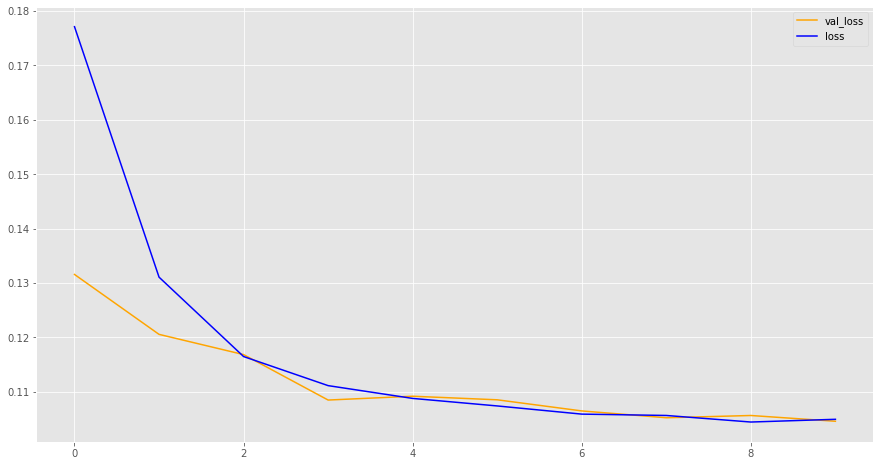

36819/36819 [==============================] - 12s 313us/sample - loss: 0.1049 - val_loss: 0.1046


In [403]:

NUMBER_OF_SAMPLES = X_train_hourOfDay.shape[0]

def get_embeding_params(X):
    NUMBER_UNIQUE_CAT = np.unique(X).shape[0]
    embedding_size = min(np.ceil(NUMBER_UNIQUE_CAT / 2), 50)  # desired feature vectore for our embedings
    embedding_size = int(embedding_size)
    vocab_size = NUMBER_UNIQUE_CAT + 1
    return vocab_size ,embedding_size


vocab_size,embedding_size =get_embeding_params(X_train_hourOfDay)
inputs_hourOfDay = keras.layers.Input(shape=(TIME_SHIFT_STEPS,))
embeddings_hourOfDay = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=TIME_SHIFT_STEPS)(
    inputs_hourOfDay)
flatten_hourOfDay = keras.layers.Flatten()(embeddings_hourOfDay)



vocab_size,embedding_size =get_embeding_params(X_train_dayOfWeek)
inputs_dayOfWeek = keras.layers.Input(shape=(TIME_SHIFT_STEPS,))
embeddings_dayOfWeek = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=TIME_SHIFT_STEPS)(
    inputs_dayOfWeek)
flatten_dayOfWeek = keras.layers.Flatten()(embeddings_dayOfWeek)


vocab_size,embedding_size =get_embeding_params(X_train_dayOfYear)
inputs_dayOfYear = keras.layers.Input(shape=(TIME_SHIFT_STEPS,))
embeddings_dayOfYear = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=TIME_SHIFT_STEPS)(
    inputs_dayOfYear)
flatten_dayOfYear=keras.layers.pooling.GlobalMaxPooling1D()(embeddings_dayOfYear)




input_time = keras.layers.Input(shape=(NUMBER_OF_FEATURE,TIME_SHIFT_STEPS ))

flatten_time = keras.layers.Flatten()(input_time)

merge = keras.layers.concatenate([flatten_hourOfDay,flatten_dayOfWeek,flatten_dayOfYear,flatten_time])

X=keras.layers.Dense(5 ,activation='relu')(merge)
X=keras.layers.Dropout(0.1)(X)
X=keras.layers.Dense(20)(X)

X=keras.layers.Dropout(0.1)(X)
X=keras.layers.Dense(10)(X)

X=keras.layers.Dense(1)(X)

model = keras.models.Model(inputs=[inputs_hourOfDay,inputs_dayOfWeek,inputs_dayOfYear, input_time], outputs=X)
model.compile(optimizer='adam', loss='mae')

model.summary()

model.fit([X_train_hourOfDay,X_train_dayOfWeek,X_train_dayOfYear,X_train],y_train, validation_data=([X_test_hourOfDay,X_test_dayOfWeek,X_test_dayOfYear,X_test],y_test), epochs=10 , batch_size=256, callbacks=[plot_losses])
model.save('model.h5')


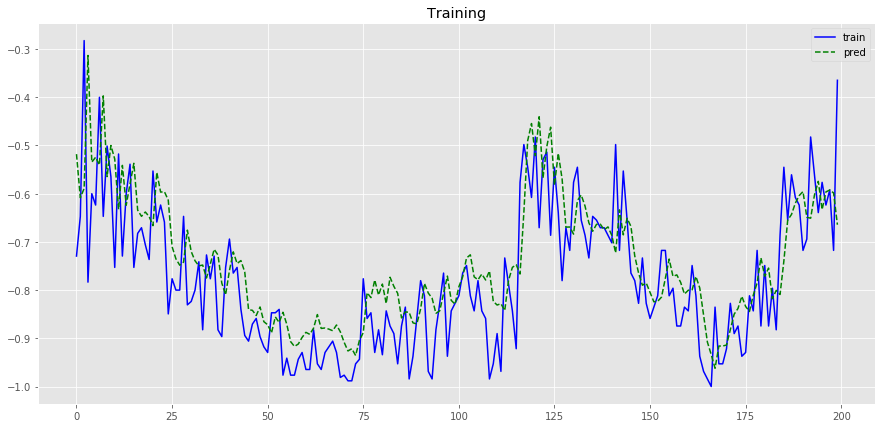

In [404]:
pred=model.predict([X_train_hourOfDay,X_train_dayOfWeek,X_train_dayOfYear,X_train])
plt.figure(figsize=(15,7))
plt.title('Training')
plt.plot(y_train[:200],'b',label='train')
plt.plot(pred[:200],'g--',label='pred')
plt.legend()
plt.show()

## Multi Live Prediction :

In [396]:
HOST = '$'
DATABASE = 'azure_ai'
USERNAME = '$'
PASSWORD = '$'
CAMERA_ID=75

class TrafficDatabaseConnector:
    def __init__(self, host, database, username, password):
        try:
            conn = psycopg2.connect(host=host, database=database, user=username, password=password)
            self.cursor = conn.cursor()
        except Exception as err:
            print(f'Failed to connect to Postgres database: {err}')

    def fetch_counts(self, camera_id=76, entity='car', time_bucket='minute', number_of_records=TIME_SHIFT_STEPS):
        """Fetches the  top {} most recent records for the {entity} from the database"""
        query=f"SELECT to_timestamp((EXTRACT(epoch FROM time) / EXTRACT(epoch FROM interval '15 min'))::int * EXTRACT(epoch FROM interval '15 min')) as phenomenonTime, avg(count) FROM public.count AS ht group by phenomenonTime, camera_id, label having label in ('car','bus','truck')  and camera_id={camera_id} order by phenomenonTime desc  LIMIT {number_of_records};"
        self.cursor.execute(query)
        return  self.cursor.fetchall()


database= TrafficDatabaseConnector(host=HOST, database=DATABASE, username=USERNAME, password=PASSWORD)
records = database.fetch_counts(camera_id=CAMERA_ID, entity='car',time_bucket='15 min',
                                                  number_of_records=2*TIME_SHIFT_STEPS)

historical=pd.DataFrame(records,columns=['phenomenonTime','result'])
historical['result']=historical['result'].astype(float)
historical.set_index(pd.DatetimeIndex(historical['phenomenonTime']),inplace=True)
historical.drop(['phenomenonTime'],inplace=True,axis=1)


NUMBER_OF_FEATURES=historical.shape[1]
#Scaling
historical_unscaled=historical.copy() # just for plotting
historical[['result']]=scaler.transform(historical['result'].values.reshape(-1,1))


train_pred ,y_train_pred = get_timeseries (historical.copy(),TIME_SHIFT_STEPS,'result')

#Training
data=historical.copy()
data.drop(['result'],inplace=True,axis=1)
data['hourOfDay']=data.index.hour
data['dayOfWeek']=data.index.dayofweek
data['dayOfYear']=data.index.dayofyear

data.head()
train_cat_pred=get_categorical(data,TIME_SHIFT_STEPS)
print('Time series data:')
display(train_pred.head())

print('Categorical series data:')
display(train_cat_pred.head())



/home/adminn/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Time series data:


,result_merged
phenomenonTime,
2019-09-01 17:15:00+00:00,"[-0.5294117647058824, -0.388235294117647, -0.1..."
2019-09-01 17:00:00+00:00,"[-0.388235294117647, -0.19999999999999996, -0...."
2019-09-01 16:45:00+00:00,"[-0.19999999999999996, -0.48235294117647065, -..."
2019-09-01 16:30:00+00:00,"[-0.48235294117647065, -0.43529411764705883, -..."
2019-09-01 16:15:00+00:00,"[-0.43529411764705883, -0.12941176470588234, -..."


Categorical series data:


,hourOfDay_merged,dayOfWeek_merged,dayOfYear_merged
phenomenonTime,,,
2019-09-01 17:15:00+00:00,"[17.0, 17.0, 16.0, 16.0, 16.0, 16.0, 16.0, 15....","[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...","[244.0, 244.0, 244.0, 244.0, 244.0, 244.0, 244..."
2019-09-01 17:00:00+00:00,"[17.0, 16.0, 16.0, 16.0, 16.0, 16.0, 15.0, 15....","[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...","[244.0, 244.0, 244.0, 244.0, 244.0, 244.0, 244..."
2019-09-01 16:45:00+00:00,"[16.0, 16.0, 16.0, 16.0, 16.0, 15.0, 15.0, 15....","[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...","[244.0, 244.0, 244.0, 244.0, 244.0, 244.0, 244..."
2019-09-01 16:30:00+00:00,"[16.0, 16.0, 16.0, 16.0, 15.0, 15.0, 15.0, 15....","[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...","[244.0, 244.0, 244.0, 244.0, 244.0, 244.0, 244..."
2019-09-01 16:15:00+00:00,"[16.0, 16.0, 16.0, 15.0, 15.0, 15.0, 15.0, 15....","[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...","[244.0, 244.0, 244.0, 244.0, 244.0, 244.0, 244..."


In [397]:
X_train_pred=np.array(train_pred['result_merged'].values.tolist()[0]).reshape(-1,1,TIME_SHIFT_STEPS)
X_train_hourOfDay_pred=np.array(train_cat_pred['hourOfDay_merged'].values.tolist()[0]).reshape(-1,TIME_SHIFT_STEPS)
X_train_dayOfWeek_pred=np.array(train_cat_pred['dayOfWeek_merged'].values.tolist()[0]).reshape(-1,TIME_SHIFT_STEPS)
X_train_dayOfYear_pred=np.array(train_cat_pred['dayOfYear_merged'].values.tolist()[0]).reshape(-1,TIME_SHIFT_STEPS)


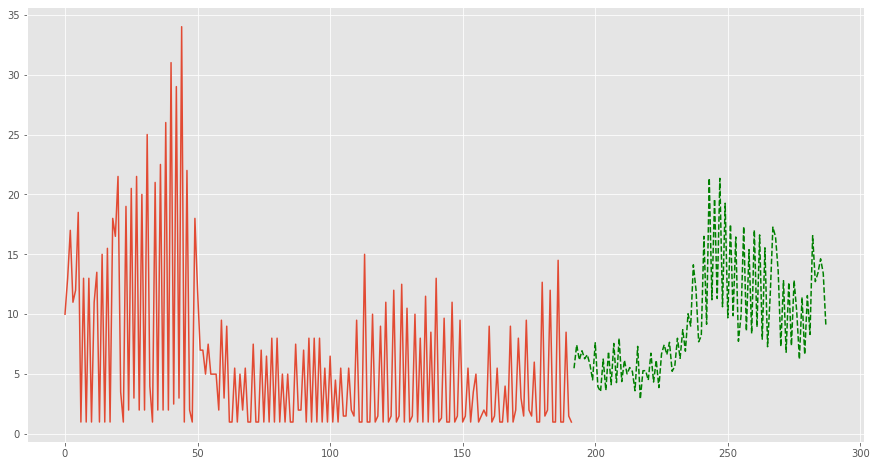

In [398]:
PRECITIONS_STEPS=96
predictions=[]
for i in range(PRECITIONS_STEPS):
    prediction = model.predict([X_train_hourOfDay_pred,X_train_dayOfWeek_pred,X_train_dayOfYear_pred,X_train_pred[:,:,:TIME_SHIFT_STEPS]] )
    predictions.append(scaler.inverse_transform(prediction)[0][0])
    X_train_pred=np.insert(X_train_pred,0,prediction[0][0],axis=2)
plt.plot(historical_unscaled['result'].values)
# plt.show()
plt.plot([i+192 for i in range(PRECITIONS_STEPS)],predictions,'g--')

